# MLP : Batch Normalization 

## Part 3 : Better init hidden layer : Solves TanH Squash problem
---
With changing of hidden layers weights to fall more or less guassian, so that TanH doesn't make it to squash

---

Kaiming init Paper : https://arxiv.org/pdf/1502.01852.pdf

BatchNorm Paper : https://arxiv.org/pdf/1502.03167.pdf

**PROBLEM**

Every linear layer causes the distribution to expand

y = W*X given below, although X, normalized, it causes the linear layer have an output y having a more spread, so to make it in mean=0 and std=1, we have to scale it down, hence we multiply it with a magic number to shrink it
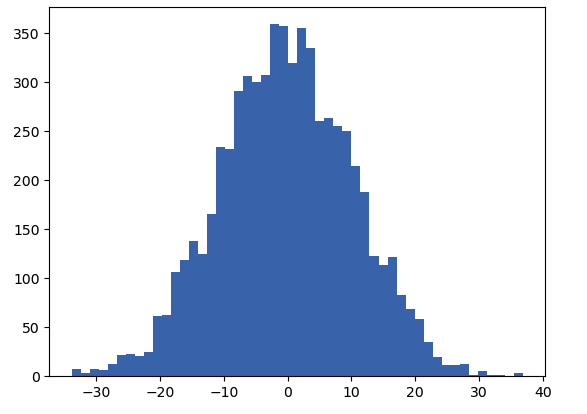


This is given by scale factor of : 
$\frac{1}{\sqrt{fin}}$

For tanH its : 
$\frac{gain}{\sqrt{fin}}$ where gain = 5/3


pytorch doc [here](https://pytorch.org/docs/stable/nn.init.html)

Kaiming init Paper : https://arxiv.org/pdf/1502.01852.pdf

In [1]:
from typing import List
import random

In [2]:
import torch
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [3]:
import torch.nn.functional as F

## 1. Data Gathering

In [4]:
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

## 2. Data Pre-Processing

In [6]:
START = END = '.'
CHARS = sorted(list(set(''.join(words))) + [START])

stoi = {char:idx for idx, char in enumerate(CHARS)}
itos = {i:s for s, i in stoi.items()}

In [7]:
print(f"\n{CHARS=}")
print(f"\n{stoi=}")
print(f"\n{itos=}")


CHARS=['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

stoi={'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}

itos={0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


### 2.1 NGrams Split

In [8]:
def get_ngrams(words: List[str], ngrams=3, debug=False):
    X, Y = list(), list()
    
    for word in words:
        if debug: print(f"-- {word} --")
        context_idxs = [stoi[START]] * (ngrams-1)
        
        for char in word+END:
            pred_idx = stoi[char]
            Y.append(pred_idx)
            X.append(context_idxs)
            
            if debug: print(f"{''.join(itos[i] for i in context_idxs)} {itos[pred_idx]}")
            context_idxs = context_idxs[1:] + [pred_idx]
            
    return torch.tensor(X), torch.tensor(Y)

In [9]:
NGRAMS = 4
CONTEXT_SIZE = NGRAMS - 1

#### 2.1.1 Train Test split

In [10]:
def split_data(data: List, ratio: float = 0.8):
    split_idx = int(ratio*len(data))
    return data[:split_idx], data[split_idx:]


In [11]:
random.shuffle(words)

train_words, test_words = split_data(data=words, ratio=0.8)
val_words, test_words = split_data(data=test_words, ratio=0.5)

assert len(words) == len(train_words) + len(val_words) + len(test_words)
len(train_words), len(val_words), len(test_words)

(25626, 3203, 3204)

In [12]:
# Complete Dataset

X_train, Y_train = get_ngrams(words=train_words, ngrams=NGRAMS, debug=False)
X_val, Y_val = get_ngrams(words=val_words, ngrams=NGRAMS, debug=False)
X_test, Y_test = get_ngrams(words=test_words, ngrams=NGRAMS, debug=False)


X_train.shape, Y_train.shape

(torch.Size([182638, 3]), torch.Size([182638]))

## 3. MLP

### 3.1 Architecture
From paper : [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

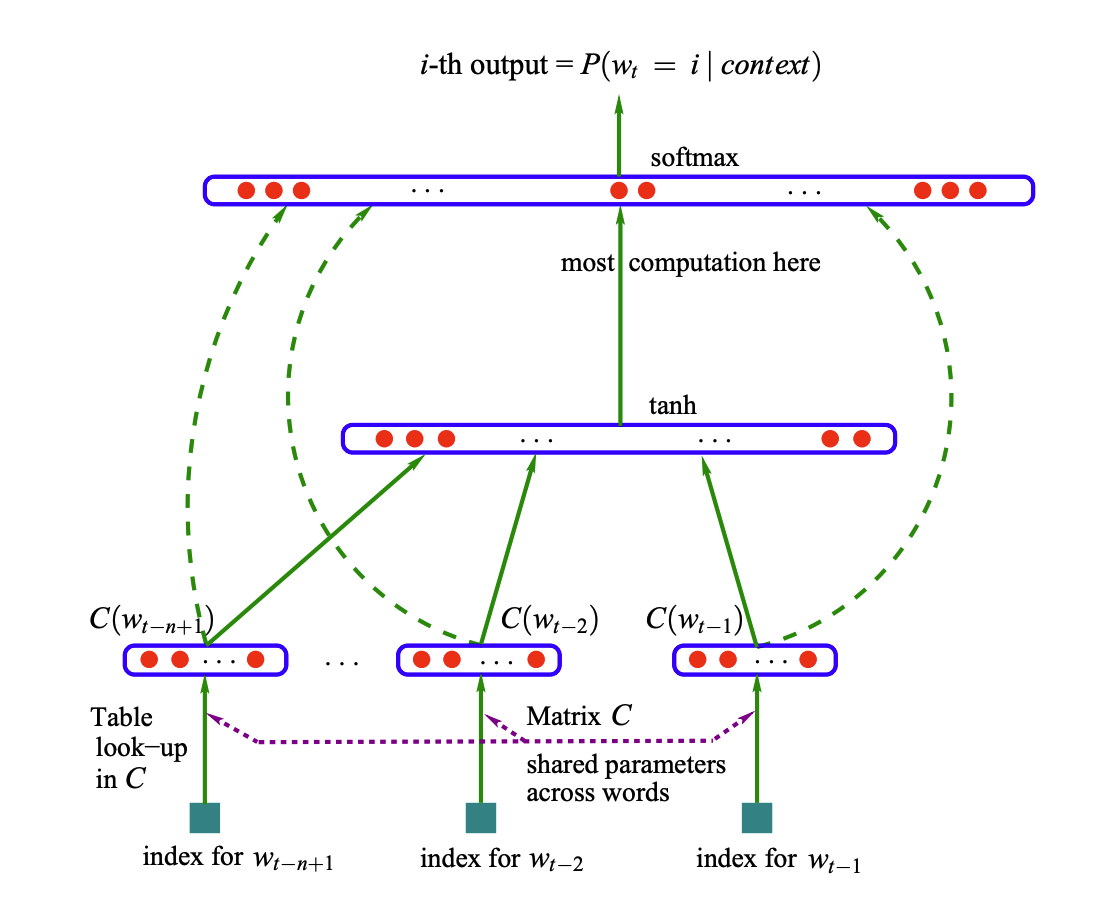

In [23]:
class MLP:
    
    def __init__(self, vocab_size, n_embd, n_positions, seed=4744):
        
        self._device = 'cpu'
        
        # Seed for reproducibility
        g = torch.Generator().manual_seed(seed)

        # Embeding Layer
        self.C = torch.randn((vocab_size, n_embd), generator=g)    

        # Hidden Layer
        self.W1 = torch.randn((CONTEXT_SIZE * n_embd, n_positions), generator=g) * (5/3)/((CONTEXT_SIZE*n_embd)**0.5)
        self.b1 = torch.randn((n_positions),                        generator=g) * 0.01

        # Output Layer
        self.W2 = torch.randn((n_positions, vocab_size),            generator=g) * 0.01     # close to 0
        self.b2 = torch.randn((vocab_size),                         generator=g) * 0        # BIAS output as 0, as we need uniform predictions for all characters.

        # Parameters
        #self.parameters = [self.C, self.W1, self.b1, self.W2, self.b2]
        print(f"Number of Model Params: {sum(p.nelement() for p in self.parameters)}")

        # Require Grads , for backprop
        self.require_grads()

    @property
    def parameters(self):   
        return [self.C, self.W1, self.b1, self.W2, self.b2]
    
    @property
    def device(self):
        return self._device
    
    def require_grads(self):
        for p in self.parameters: p.requires_grad = True
            
    def __call__(self, x):
        
        # Forward call
        self.emb = self.C[x]     
        self.hpreact = self.emb.view(self.emb.shape[0], -1) @ self.W1 + self.b1
        self.h = torch.tanh(self.hpreact) 
        self.logits = self.h @ self.W2 + self.b2                                        
        return self.logits
  
    def to(self, device):
        if not torch.cuda.is_available():
            print(f"Cuda not available")
            return
        
        self.C = self.C.detach().to(device)
        self.W1 = self.W1.detach().to(device)
        self.b1 = self.b1.detach().to(device)
        self.W2 = self.W2.detach().to(device)
        self.b2 = self.b2.detach().to(device)
            
        self._device = device
        self.require_grads()

### 3.2 Training Loop

In [24]:
class Trainer:
    
    def __init__(self, model):
        self.model = model
        self.losses = list()
        self.epochs = 0
    
    @staticmethod
    def get_batch_idxs(x, batch_size):
        return torch.randint(0, x.shape[0], size=(batch_size,))
        
    def train(self, x, y, batch_size=32, epochs=10, lrs=(0.1, 0.01), lr_decay_epoch=5):
        print(f"Dataset size: {len(x)}")
        epochs += self.epochs
        delta_epochs = epochs - self.epochs
        
        for epoch in tqdm(range(self.epochs, epochs), desc="Epochs"):
            # Batch indexes
            ix = self.get_batch_idxs(x, batch_size=batch_size)
            _x = x[ix].to(self.model.device)
            _y = y[ix].to(self.model.device)
            
            # Forward
            logits = self.model(_x)
            loss = F.cross_entropy(logits, _y)
            if epoch in {self.epochs} or epoch % int(delta_epochs/10) == int(delta_epochs/10) - 1: print(f"Loss {epoch+1}/{epochs}: {loss.item()}")
            self.losses.append(loss.item())

            # Backward
            for p in model.parameters: p.grad = None
            loss.backward()

            # Optimizer
            lr = lrs[0] if epoch < lr_decay_epoch else lrs[1]
            for p in model.parameters: p.data -= lr * p.grad
            
        self.epochs += delta_epochs
        return self.losses
    
    @torch.no_grad()
    def evaluate(self, x, y):
        x = x.to(self.model.device)
        y = y.to(self.model.device)
        
        logits = self.model(x)
        loss = F.cross_entropy(logits, y)
        return loss
    
    def plot(self):
        if len(self.losses) <= 1:
            print(f"Model Final loss: {self.losses[-1]}")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        fig.figsize=(20, 10)
        ax1.plot(self.losses); ax1.set(title="Loss", xlabel="Epochs", ylabel="loss")
        ax2.plot(list(map(torch.log10, torch.tensor(self.losses)))); ax2.set(title="Log Loss", xlabel="Epochs", ylabel="loss = 10^x") 
        print(f"Model Final loss: {self.losses[-1]}")

#### 3.2.1 Training

In [25]:
N_EMBD = 30
N_POSITIONS = 200

BATCH_SIZE = 32

In [26]:
# INIT MODEL

model = MLP(vocab_size=len(CHARS), n_embd=N_EMBD, n_positions=N_POSITIONS)
model.to("cuda:1")
model.C.device

Number of Model Params: 24437


device(type='cuda', index=1)

In [27]:
# Init Trainer
trainer = Trainer(model=model)

In [28]:
# Train 

losses = trainer.train(x=X_train, y=Y_train, batch_size=BATCH_SIZE, epochs=1, lrs=(0.1, 0.01), lr_decay_epoch=100_000)
trainer.plot()

Dataset size: 182638


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Loss 1/1: 3.3079583644866943
Model Final loss: 3.3079583644866943


#### 3.2.2 Observation

Better starting loss

In [29]:
model.h, model.h.shape

(tensor([[ 0.9991, -0.9665,  0.9614,  ...,  0.9644,  0.8126,  0.7398],
         [ 0.9665, -0.0211,  0.2053,  ...,  0.6755, -0.2233, -0.9492],
         [ 0.9934,  0.4533, -0.9473,  ..., -0.8277,  0.8509, -0.8334],
         ...,
         [ 0.7462, -0.9827, -0.9752,  ..., -0.5928, -0.9348, -0.8939],
         [ 0.9943, -0.9926, -0.4235,  ..., -0.4638,  0.1400, -0.8420],
         [ 0.6909, -0.8258,  0.7294,  ...,  0.8378,  0.9980,  0.4969]],
        device='cuda:1', grad_fn=<TanhBackward0>),
 torch.Size([32, 200]))

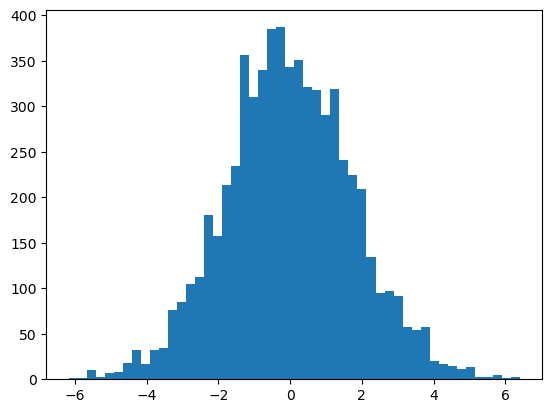

In [30]:
# ouptut of hidden layer, before TanH
fig = plt.hist(model.hpreact.view(-1).tolist(), 50)

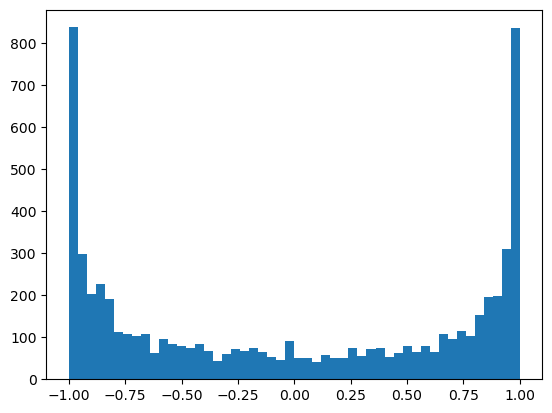

In [31]:
# output of hidden layer after TanH
fig = plt.hist(model.h.view(-1).tolist(), 50)

This causes the gradient to vanish or 0

derivative of tanh = (1 - tanh^2) * prev.grad

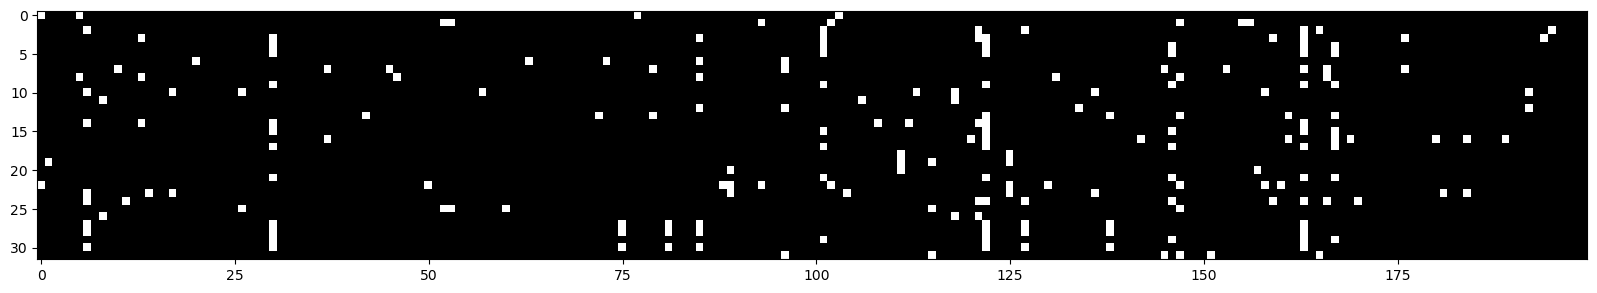

In [32]:
plt.figure(figsize=(20, 10))
plt.imshow(model.h[:100].abs().cpu() >= 0.999, cmap='gray', interpolation='nearest')

**(LESSER WHITE, BETTER it is)**


We see above that, white area is where the tanH is very close to abs(1, -1) or is abs(1, -1)

This suggest that, these neurons gradients where 0, and it was never fired.

NOTE: if complete column was white, it means that neuron was never activated (dead Neuron), we don't have in this case although.

**BRAIN Damage**

Phenomenon where a neuron just doesn't activate, bcs, it activation comes out at flat region of the curve. This could happen in , TanH, RelU, Sigmoid etc, who has flat tails.

This could happen due to: 
    
    - Bad init of weights, causing a neuron to never learn.
    - Gradients adjusted with very high lr, and it now started to fall in the flat region.

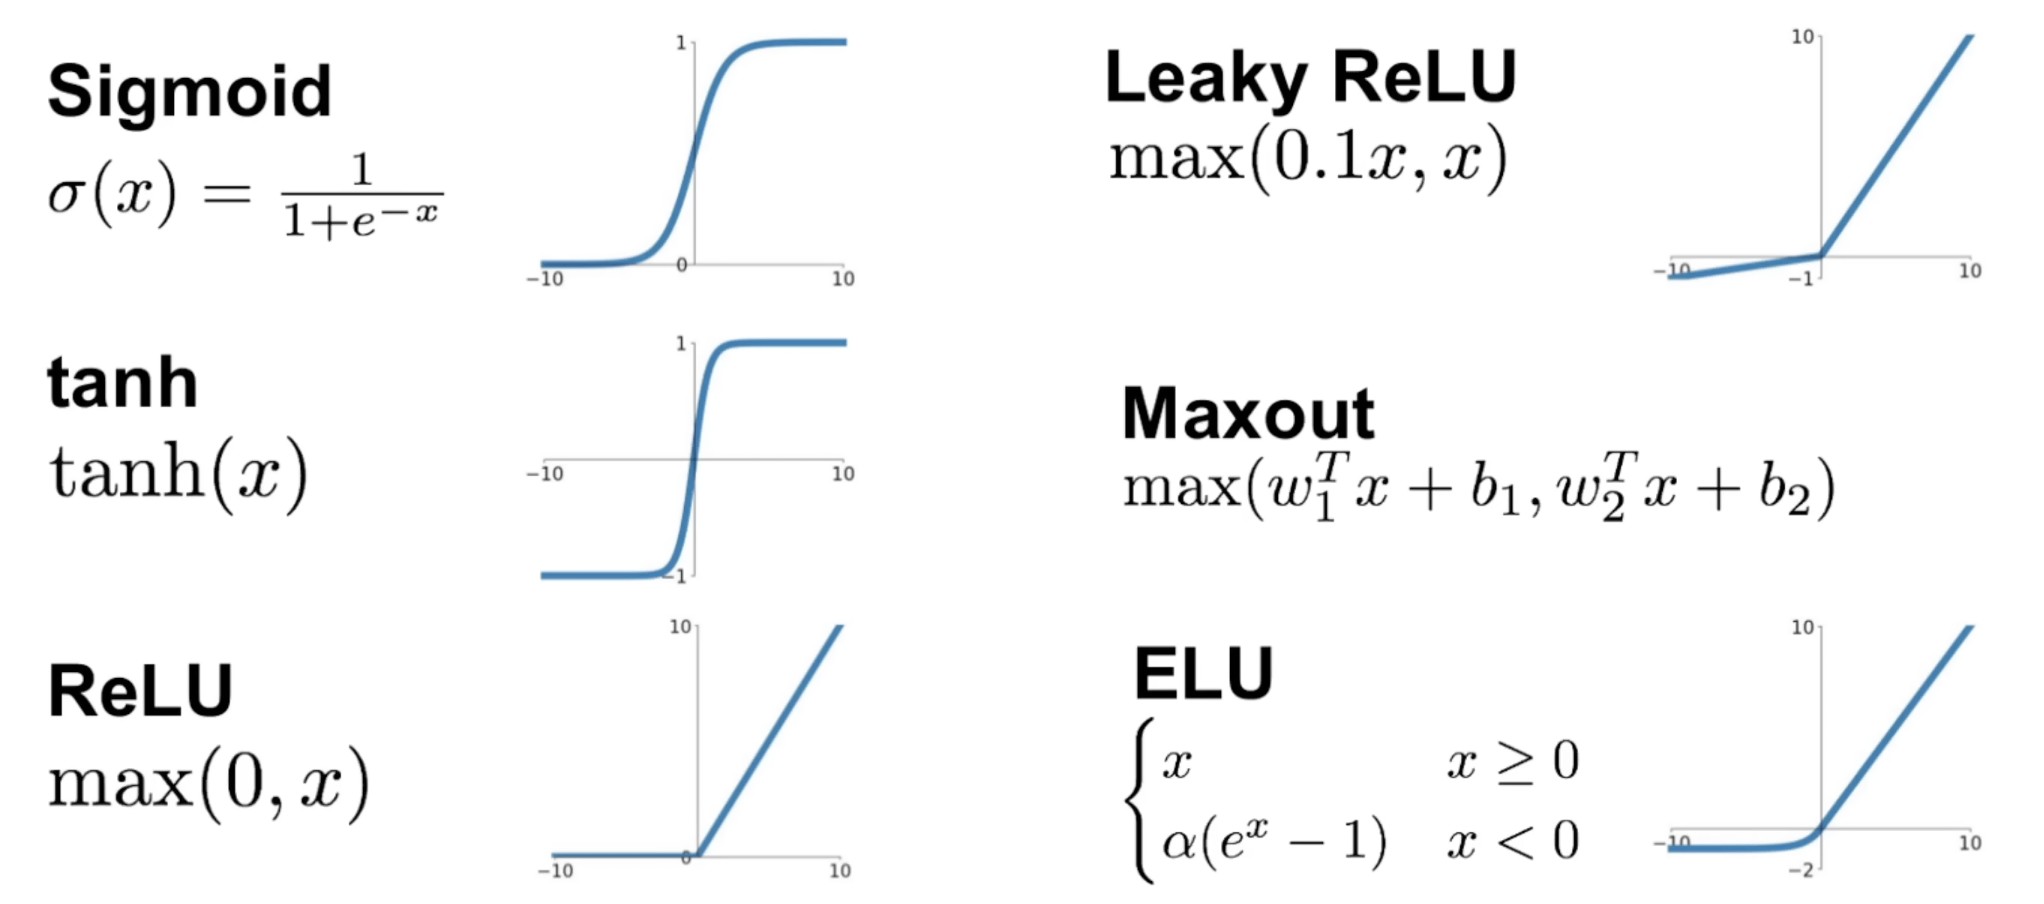

**Solution**

- 1. Better init the layers, (linear layer) which goes through activation, 
- 2. Normalize the output of the layer. (Normalization Techniques)

#### 3.2.3 Continue Training

Dataset size: 182638


Epochs:   0%|          | 0/50000 [00:00<?, ?it/s]

Loss 50002/100001: 2.03841233253479
Loss 55000/100001: 2.3250370025634766
Loss 60000/100001: 1.8836054801940918
Loss 65000/100001: 2.0393784046173096
Loss 70000/100001: 1.843924880027771
Loss 75000/100001: 2.248192310333252
Loss 80000/100001: 2.0205626487731934
Loss 85000/100001: 2.313283920288086
Loss 90000/100001: 2.2693912982940674
Loss 95000/100001: 1.986313819885254
Loss 100000/100001: 2.423128128051758
Model Final loss: 2.109783887863159


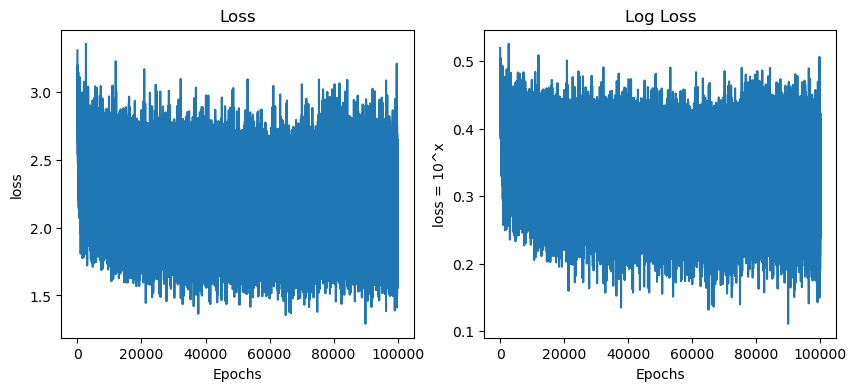

In [36]:
# Train 

losses = trainer.train(x=X_train, y=Y_train, batch_size=BATCH_SIZE, epochs=50_000, lrs=(0.1, 0.01), lr_decay_epoch=75_000)
trainer.plot()

## 4. Evaluate

In [37]:
print(f"Train Loss: {trainer.evaluate(x=X_train, y=Y_train)}")
print(f"Val Loss: {trainer.evaluate(x=X_val, y=Y_val)}")
print(f"Test Loss: {trainer.evaluate(x=X_test, y=Y_test)}")

Train Loss: 2.1366589069366455
Val Loss: 2.1853830814361572
Test Loss: 2.213728904724121
